## Train ViT-B-16 on CIFAR-10

In [1]:
import torch
import utils
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
MODEL_NAME = 'ViT-B-16'
DATASET_NAME = 'CIFAR-10'
BATCH_SIZE = 32
EPOCHS = 200
IMG_SIZE = 32
NUM_CLASSES = 10

In [4]:
#imagenet_model = torchvision.models.vit_b_16(weights='IMAGENET1K_V1')
model = torchvision.models.vit_b_16(image_size=IMG_SIZE, num_classes=NUM_CLASSES)
#model.parameters = imagenet_model.parameters
#del imagenet_model
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Files already downloaded and verified
Files already downloaded and verified


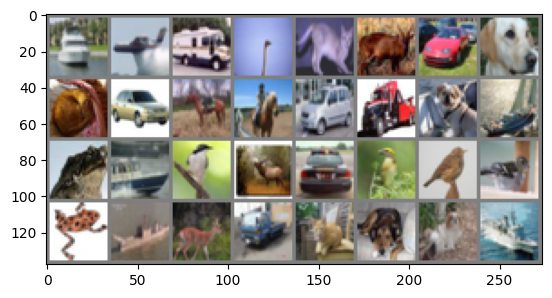

ship  plane truck bird  cat   deer  car   dog   cat   car   horse horse car   truck dog   ship  frog  ship  bird  deer  car   bird  bird  bird  frog  ship  deer  truck cat   dog   dog   ship 


In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

data_iter = iter(train_loader)
images, labels = next(data_iter)

utils.imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

In [ ]:
best_accuracy = 0.0
best_train_acc = 0.0
    
for epoch in range(EPOCHS):

    train_loaders = [train_loader]

    for train_loader in train_loaders:

        train_correct_preds_batches = []
        train_count = 0
        
        for i, (images, labels) in enumerate(train_loader):

            if torch.cuda.is_available():
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())

            optimizer.zero_grad()

            outputs = model(images)
            preds = torch.argmax(outputs, 1)
            
            train_loss = criterion(outputs, labels)
            train_loss.backward()
            optimizer.step()

            train_correct_preds_batch = (preds == labels).sum().item()
            train_correct_preds_batches.append(train_correct_preds_batch)
            train_count = train_count+len(images)
            train_acc = round(np.sum(train_correct_preds_batches)/train_count, 4)

            print(f'{train_count} -> {train_acc}')

    test_loaders = [test_loader]

    with torch.no_grad():
        
        for test_loader in test_loaders:

            test_correct_preds_batches = []
            test_count = 0
            
            for i, (images, labels) in enumerate(test_loader):
    
                if torch.cuda.is_available():
                    images = Variable(images.cuda())
                    labels = Variable(labels.cuda())
    
                outputs = model(images)
                preds = torch.argmax(outputs, 1)
                
                test_loss = criterion(outputs, labels)
    
                test_correct_preds_batch = (preds == labels).sum().item()
                test_correct_preds_batches.append(test_correct_preds_batch)
                test_count = test_count+len(images)
                test_acc = round(np.sum(test_correct_preds_batches)/test_count, 4)

                print(f'{test_count} -> {test_acc}')

    print(f'Epoch {epoch+1}, Train accuracy: {train_acc}, Test accuracy: {test_acc}')

32 -> 0.0625
64 -> 0.0781
96 -> 0.0938
128 -> 0.0859
160 -> 0.0938
192 -> 0.0938
224 -> 0.1071
256 -> 0.1016
288 -> 0.1042
320 -> 0.1
352 -> 0.1023
384 -> 0.1042
416 -> 0.1034
448 -> 0.1004
480 -> 0.0979
512 -> 0.1016
544 -> 0.1029
576 -> 0.1076
608 -> 0.1069
640 -> 0.1109
672 -> 0.1161
704 -> 0.1222
736 -> 0.125
768 -> 0.125
800 -> 0.1288
832 -> 0.1298
864 -> 0.1331
896 -> 0.1328
928 -> 0.139
960 -> 0.1417
992 -> 0.1401
1024 -> 0.1416
1056 -> 0.1411
1088 -> 0.1397
1120 -> 0.1393
1152 -> 0.1398
1184 -> 0.1419
1216 -> 0.1456
1248 -> 0.149
1280 -> 0.1477
1312 -> 0.1463
1344 -> 0.1436
1376 -> 0.1424
1408 -> 0.1399
1440 -> 0.1403
1472 -> 0.142
1504 -> 0.1423
1536 -> 0.1426
1568 -> 0.1422
1600 -> 0.1425
1632 -> 0.1422
1664 -> 0.1418
1696 -> 0.1409
1728 -> 0.14
1760 -> 0.1392
1792 -> 0.139
1824 -> 0.1414
1856 -> 0.1422
1888 -> 0.1409
1920 -> 0.1401
1952 -> 0.1399
1984 -> 0.1396
2016 -> 0.1424
2048 -> 0.1431
2080 -> 0.1433
2112 -> 0.142
2144 -> 0.1423
2176 -> 0.1429
2208 -> 0.144
2240 -> 0.14